In [7]:
rm(list = ls())
options(warn=-1)
options(repr.matrix.max.rows=40, repr.matrix.max.cols=200)
packages = list("dplyr","ROCR","glmnet","ggplot2",
            "WriteXLS","pROC","SDMTools","caTools","tableone")
invisible(sapply(packages,library,character.only = TRUE))

In [10]:
### bind 3 columns into a single columns
bind_ci = function(model_name, ci){
    ci = round(ci,digits = 2)
    cat(model_name,": ",ci[2],"(",ci[1],"-",ci[3],")","\n", sep = "")
}

### Plot confidence Intervals
plot_ci = function(names, title, tab){
    library(plotrix)
    
    plotCI(tab[,2],
           uiw=tab[,3]-tab[,2],
           liw=tab[,2]-tab[,1],
           pch=10,
           main = title,
           xlab = "Models",
           ylab = 'Area Under ROC curves and 95% Confidence Intervals',
           at = c(1:length(names)),
           labels = names)
        
    }


### Plot AUCs
plot_auc = function(names, title, rocs){
    
    line_col = c(scales::alpha('red',0.7),scales::alpha('blue',0.7),'purple','green','yellow')
    line_width = c(2,rep(1,length(rocs)-1))*2

    
    for (i in 1 : length(rocs))
    {
        plot(main = title,
             rocs[[i]],
             lwd = line_width[i],
             col = line_col[i])
        par(new = TRUE)
        }
    
    legend('bottomright',
           names,
           fill = line_col, bty = 'n',
           border = NA)
    
}


In [17]:
cur_dir = getwd()
data_dir = file.path(cur_dir,"..", 'data')
setwd(data_dir)
data_NUS = readxl::read_excel("Book1.xlsx") %>%
           purrr::map(as.numeric) %>% as.data.frame

### Extract required fields 
data_NUS =          sqldf::sqldf("select
                      
                      [Status.at.Presentation.with.Symptoms..0.outpatient.EMD..1.inpatient.] as [P_type],
                      [Age_raw] as [Age],
                      [Temp...C.] as [Temp],
                      [PESI.Gender..Male.sex...10..Female...0.] as [Gender],
                      [PESI.Cancer..Active.CA..60.] as [Cancer_active],
                      [Surgery.in.last.30.days..0.N..1.Y.] as [Surgery],
                      [Immobile..0.N..1.Y.] as [Immobile],
                      [Previous.VTE..0.N..1.Y.] as [VTE],
                      [Thrombophilia..e.g..Protein.C.S.antithrombin.deficiency..APS...0.N..1.Y.] as [Thrombophilia],
                      [PESI.CCF..Heart.failure..10.] as [Heart_failure],
                      [PESI.CLD..Chronic.lung.disease..10.] as [Lung_disease],
                      [Coronary...Peripheral.Artery.Disease..0.N..1.Y.] as [Coronary_Peripheral_Artery_Disease],
                      [Prior.Stroke...TIA..0.N..1.Y.] as [Stroke_TIA],
                      [Concurrent.sepsis..0.N..1.Y.]  as [Concurret_Sepsis],
                      [Symptoms.of.DVT..0.N..1.Y.] as [DVT],
                      [PESI.HR...110..20.] as [HR],
                      [PESI.SpO2.90..20] as [SaO2],
                      [PESI.RR...30..20.] as [RR],
                      [PESI.BP...100..30.] as [BP],
                      [Initial.Drug...0.none..1.warfarin..2.LMWH..3.NOAC..4.heparin..5.tPA..6.others.] as [Init_drug],
                      [Temp...C.] as [Temp],
                      [PESI.AMS..60] as [AMS],
                      [IV_required..0.N..1.Y.] as [IV_required],
                      [ALT],
                      [Haemoptysis..0.N..1.Y.] as [Hemoptysis],
                      [Anticoagulated.Prior.to.Dx..0.N.or.non.compliant..1.Y.] as [Anticoagulated_history],
                      [Subsequent.adm.related.to.PE..0.No..1.Yes.] as [Subseq_adm_PE],
                      [LOS..days.] as [LOS],
                      [Major.Bleed.within.30.days..0.N..1.Y.] as [Major_bleed_30],
                      [PESI.Score] as [PESI],
                      [Simplified.PESI.Score] as [sPESI],
                      [Agriman_Score] as [Angriman],
                      [ESC.Risk..0.low..1.int.low..2.int.high..3.high.] as [ESC],
                      [Simplified_Angriman_Score] as [sAngriman],
                      (case when [X1.week.mortality..0.dead..1.alive.] = 1 then 0
                      else 1 end) as [Mortality_week],
                      (case when [X30.day.mortality..0.dead..1.alive.] = 1 then 0
                      else 1 end) as [Mortality]
     
                      from data_NUS"

                       )

### Expand Initial_Drug
data_NUS['Init_drug_none'] = ifelse(data_NUS$Init_drug == 0 , 1, 0)
data_NUS['Init_drug_warfarin'] = ifelse(data_NUS$Init_drug == 1 , 1, 0)
data_NUS['Init_drug_LMWH'] = ifelse(data_NUS$Init_drug == 2 , 1, 0)
data_NUS['Init_drug_DOAC'] = ifelse(data_NUS$Init_drug == 3 , 1, 0)
data_NUS['Init_drug_heparin'] = ifelse(data_NUS$Init_drug == 4 , 1, 0)
data_NUS['Init_drug_tPA'] = ifelse(data_NUS$Init_drug == 5 , 1, 0)
data_NUS['Init_drug_others'] = ifelse(data_NUS$Init_drug == 6 , 1, 0)
data_NUS = subset(data_NUS , select = -c(Init_drug))
data_NUS['new_model'] = readRDS('new_score3.Rda')

###load imputed ALT data that is generated 
data_NUS$ALT = readRDS('ALT.Rda')


### Convert PESI predictors with assigned score into binary. 
data_NUS[c('Gender','Cancer_active', 'Heart_failure', 'Lung_disease','HR','BP','RR','AMS','SaO2')] = 
ifelse(data_NUS[c('Gender','Cancer_active', 'Heart_failure', 'Lung_disease','HR','BP','RR','AMS','SaO2')]!=0 , 1,0)


### impute some of required fields with missing values using KNN imputation
data_NUS = DMwR::knnImputation(data_NUS, k = 3, scale = T, meth = "weighAvg")


### Threshold was set on imputed fields 
data_NUS$Anticoagulated_history = ifelse(data_NUS$Anticoagulated_history > 0.5 , 1 , 0 )
data_NUS$Stroke_TIA = ifelse(data_NUS$Stroke_TIA > 0.5 , 1 , 0 )
data_NUS$ALT = ifelse(data_NUS$ALT > 75, 1 , 0 )


data_NUS$Thrombophilia = ifelse(data_NUS$Thrombophilia == 9,0,data_NUS$Thrombophilia)
data_NUS$Thrombophilia = ifelse(data_NUS$Thrombophilia == 2,1,data_NUS$Thrombophilia)

new_model: 0.79(0.66-0.93)
PESI: 0.67(0.49-0.84)
sPESI: 0.58(0.39-0.77)
ESC: 0.63(0.43-0.82)
Angriman: 0.67(0.52-0.82)


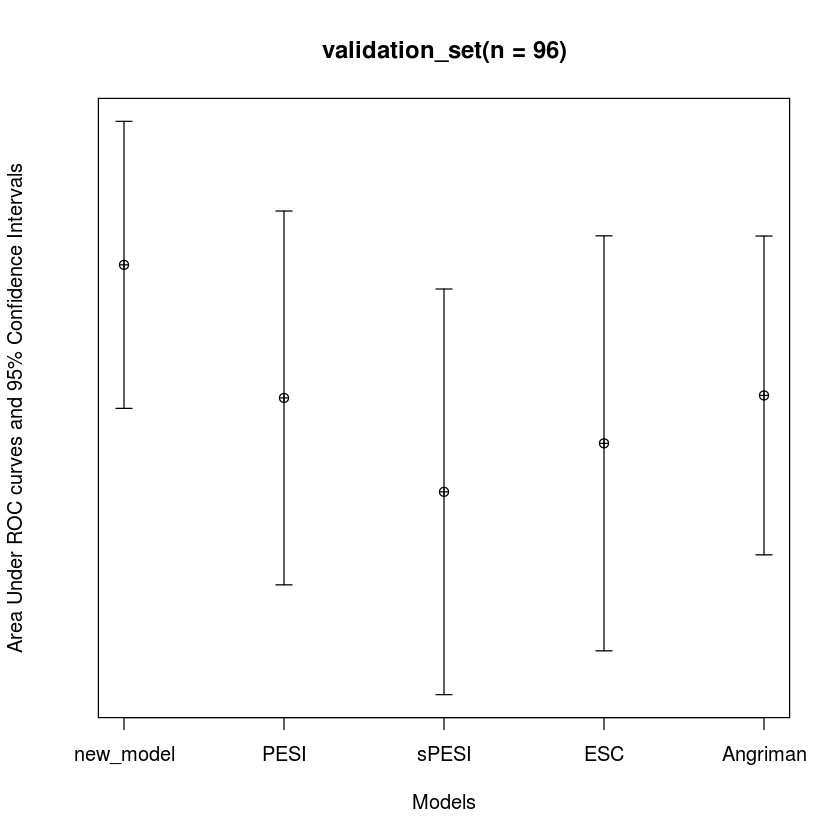

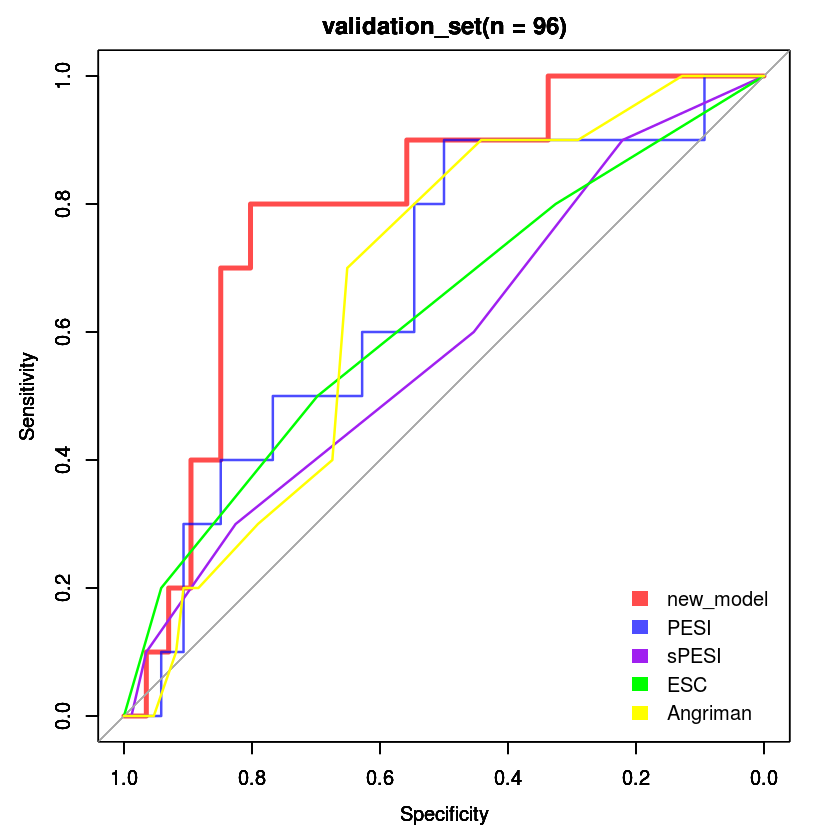

In [19]:
### set.seed 
set.seed(187)


### split data into trainset and testset
splitIndex = sample.split(data_NUS$Mortality, SplitRatio = 0.7)
Index_test = which(splitIndex == FALSE)
Index_train = which(splitIndex == TRUE)


### plot AUC and Confidence Interval
scores = c('new_model' ,'PESI','sPESI','ESC','Angriman')  
scores_auc = c('auc_new' ,'auc_PESI_score','auc_sPESI_score','auc_ESC_score','auc_Angriman_score')  
roc_test = list()
auc_test = list()
tab = data.frame()

for  (i in 1:length(scores))
    {
  roc_test[[i]] = as.list(roc(data_NUS[Index_test,'Mortality'], data_NUS[Index_test,scores[i]], ci = TRUE,))
  tab = rbind(tab,roc_test[[i]]$ci)  
  bind_ci(scores[i], roc_test[[i]]$ci)
    }

plot_ci(scores,"validation_set(n = 96)",tab)
plot_auc(scores,"validation_set(n = 96)",roc_test)


new_model: 0.83(0.76-0.9)
PESI: 0.67(0.55-0.8)
sPESI: 0.58(0.45-0.71)
ESC: 0.66(0.55-0.78)
Angriman: 0.66(0.54-0.78)


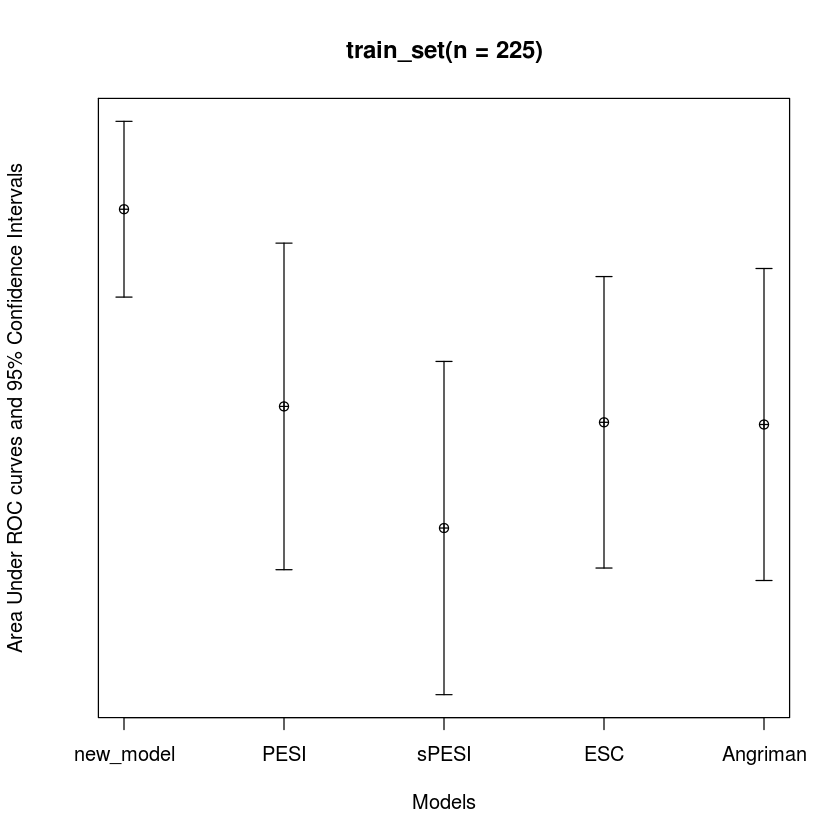

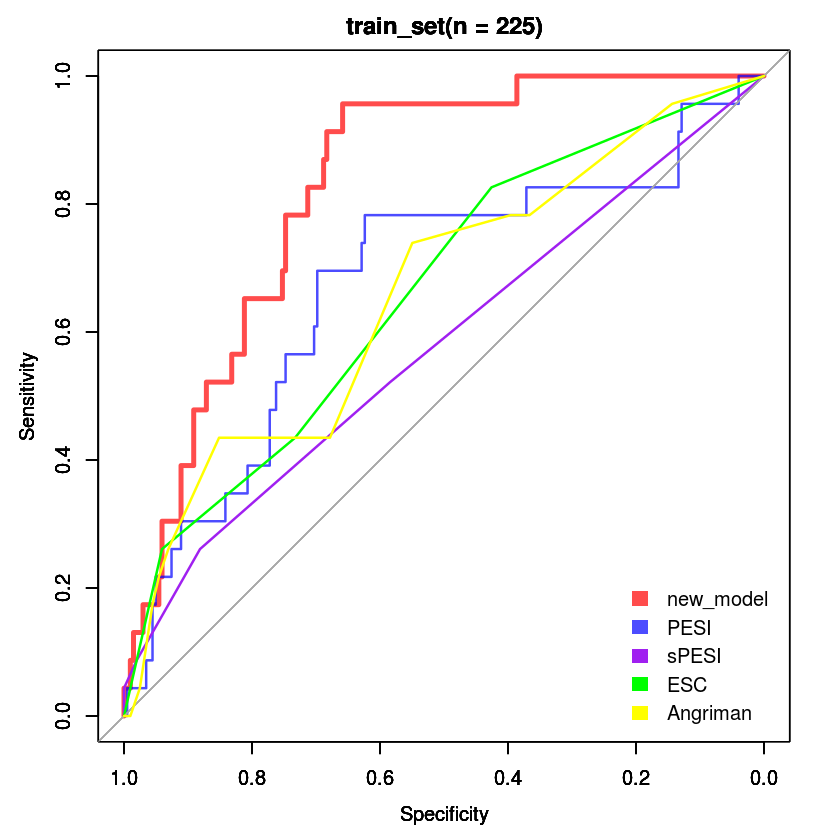

In [20]:
roc_train = list()
auc_train = list()
tab = data.frame()


### plot AUC and Confidence Interval
for  (i in 1:length(scores))
    {
  roc_train[[i]] = as.list(roc(data_NUS[Index_train,'Mortality'], data_NUS[Index_train,scores[i]], ci = TRUE,))
  tab = rbind(tab,roc_train[[i]]$ci)  
  bind_ci(scores[i], roc_train[[i]]$ci)
    }

plot_ci(scores,"train_set(n = 225)",tab)
plot_auc(scores,"train_set(n = 225)",roc_train)

new_model: 0.82(0.76-0.88)
PESI: 0.67(0.57-0.78)
sPESI: 0.58(0.48-0.69)
ESC: 0.65(0.55-0.75)
Angriman: 0.67(0.57-0.76)


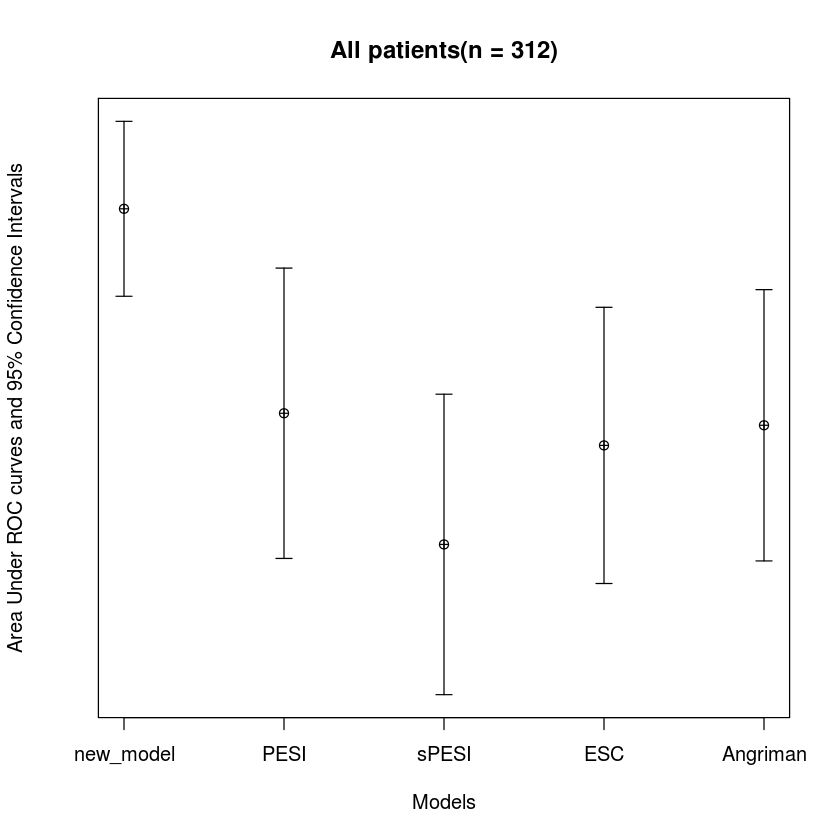

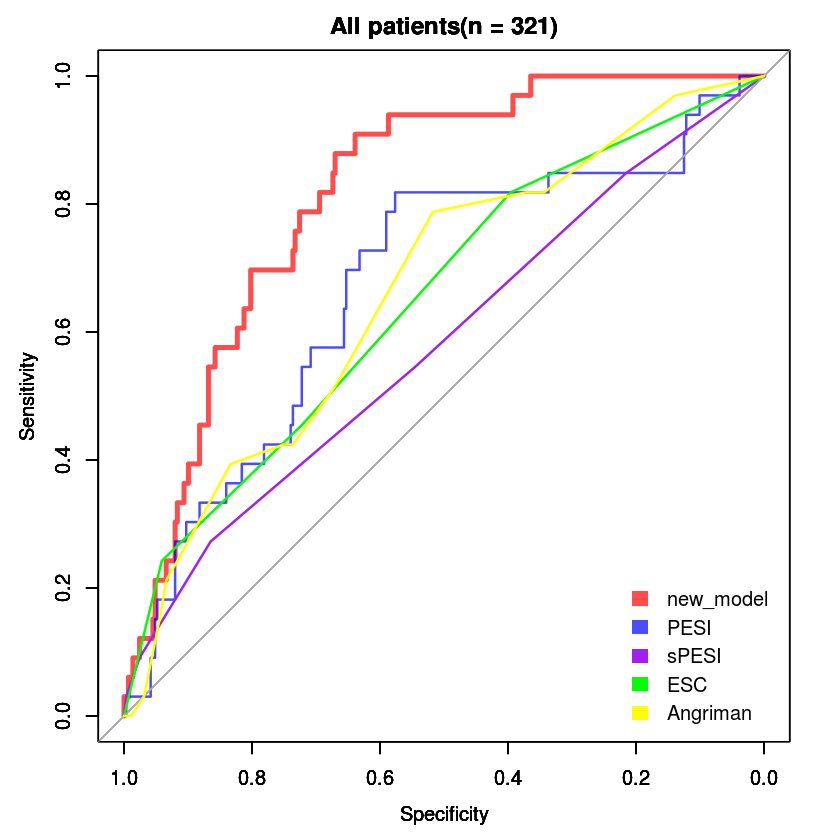

In [21]:
roc_all = list()
auc_all = list()
tab = data.frame()


### plot AUC and Confidence Interval
for  (i in 1:length(scores))
    {
  roc_all[[i]] = as.list(roc(data_NUS[,'Mortality'], data_NUS[,scores[i]], ci = TRUE,))
  tab = rbind(tab,roc_all[[i]]$ci)  
  bind_ci(scores[i],roc_all[[i]]$ci)
    }

plot_ci(scores,"All patients(n = 312)",tab)
plot_auc(scores,"All patients(n = 321)",roc_all)

new_model: 0.79(0.65-0.94)
PESI: 0.88(0.81-0.96)
sPESI: 0.7(0.48-0.92)
ESC: 0.71(0.48-0.93)
Angriman: 0.76(0.59-0.93)


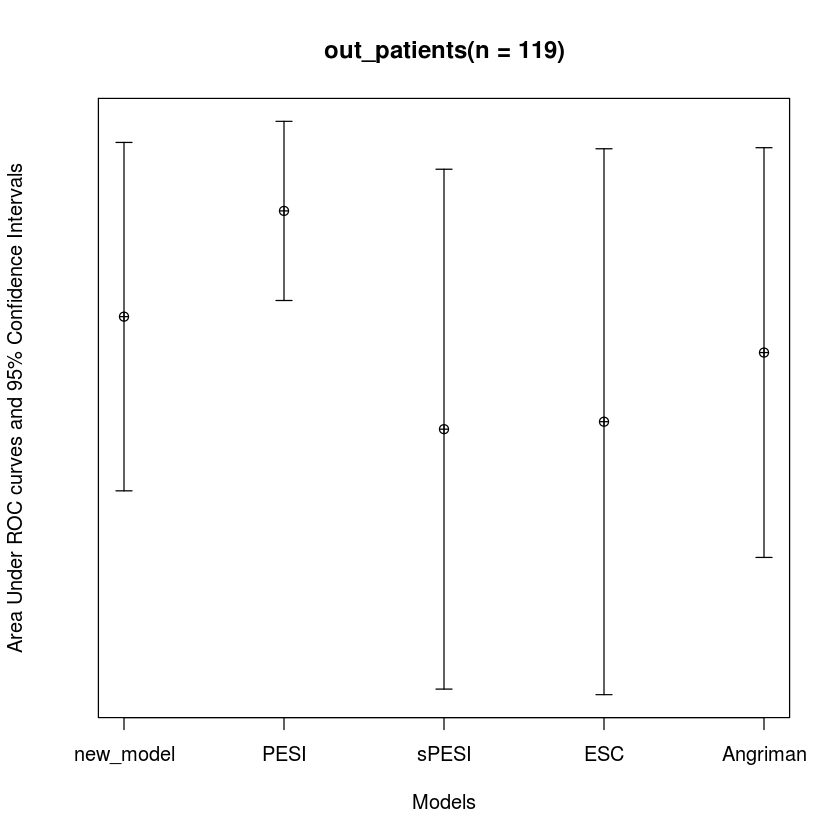

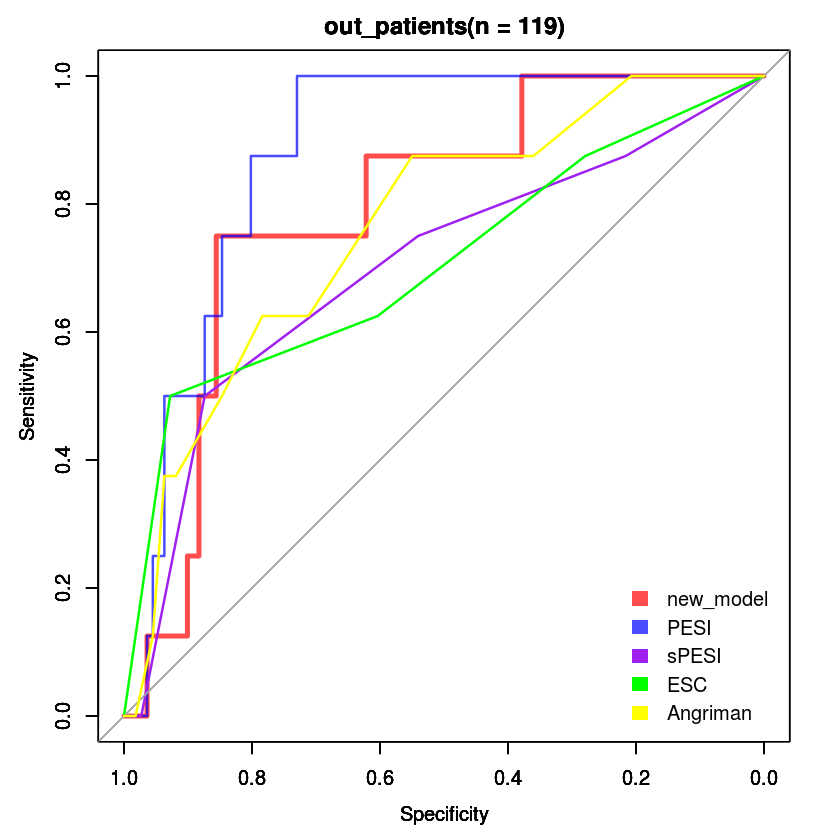

In [22]:
roc_op = list()
auc_op = list()
tab = data.frame()


### plot AUC and Confidence Interval
for  (i in 1:length(scores))
    {
  roc_op[[i]] = as.list(roc(data_NUS[data_NUS$P_type == 0,'Mortality'], data_NUS[data_NUS$P_type == 0,scores[i]], ci = TRUE,))
  tab = rbind(tab,roc_op[[i]]$ci)  
  bind_ci(scores[i], roc_op[[i]]$ci)
    }

plot_ci(scores,"out_patients(n = 119)", tab)
plot_auc(scores,"out_patients(n = 119)", roc_op)

In [23]:
### Extract characteristics of our interest
characteristics = subset(data_NUS, select  =  c(Age,
                                                Gender,
                                                Cancer_active,
                                                Surgery,
                                                Immobile,
                                                VTE,
                                                Thrombophilia,
                                                Heart_failure,
                                                Lung_disease,
                                               `Coronary_Peripheral_Artery_Disease`,
                                               `Stroke_TIA`,
                                                Concurret_Sepsis,
                                                DVT,
                                               `HR`,
                                               `SaO2`,
                                               `RR`,
                                               `BP`,
                                                AMS,
                                                IV_required,
                                                ALT,
                                                Hemoptysis,
                                                Anticoagulated_history,
                                                Init_drug_none,
                                                Init_drug_warfarin,
                                                Init_drug_LMWH,
                                                Init_drug_DOAC,
                                                Init_drug_heparin,
                                                Init_drug_tPA,
                                                Init_drug_others
                
                                               ))


### Set cut-off points for each of stratification models
scores = c('new_model' ,'PESI','sPESI','ESC','Angriman','sAngriman')  
score_cutoff = c(100,86,1,1,4,2)


### Plot basline characteristics difference between low_risk and high_risk
cat_var = names(characteristics)[-1]
tab = list()

for (i in 1:length(scores))
{
    
characteristics$trt = ifelse(data_NUS[scores[i]] < score_cutoff[i], 'low', 'high')
characteristics$trt = paste0(characteristics$trt,"(",scores[i],")")
tab[[i]] = CreateTableOne(vars = names(characteristics), strata = "trt", data = characteristics, factorVars = cat_var)
tab[[i]] = print(tab[[i]], exact = "stage", quote = FALSE, noSpaces = TRUE, printToggle = FALSE, format = c("fp", "f", "p", "pf")[3])
}

do.call(cbind,lapply(tab,function(x){
    x[,c(2,1)]
}))

,low(new_model),high(new_model),low(PESI),high(PESI),low(sPESI),high(sPESI),low(ESC),high(ESC),low(Angriman),high(Angriman),low(sAngriman),high(sAngriman)
n,195,126,110,211,67,254,120,201,105,216,165,156
Age (mean (sd)),57.52 (16.77),66.47 (13.12),51.80 (15.68),65.85 (14.00),57.20 (13.51),62.05 (16.50),59.04 (15.20),62.23 (16.42),58.86 (18.02),62.09 (14.89),55.80 (16.27),66.57 (13.80)
Gender = 1 (%),47.7,49.2,47.3,48.8,55.2,46.5,52.5,45.8,51.4,46.8,53.9,42.3
Cancer_active = 1 (%),32.3,23.0,8.2,39.3,0.0,36.2,42.5,20.4,0.0,42.6,15.2,42.9
Surgery = 1 (%),24.1,27.8,20.9,28.0,20.9,26.8,28.3,23.9,16.2,30.1,18.8,32.7
Immobile = 1 (%),22.6,31.7,16.4,31.3,17.9,28.3,24.2,27.4,21.0,28.7,21.2,31.4
VTE = 1 (%),16.9,17.5,24.5,13.3,23.9,15.4,16.7,17.4,15.2,18.1,19.4,14.7
Thrombophilia = 1 (%),5.1,4.0,7.3,3.3,7.5,3.9,4.2,5.0,6.7,3.7,6.1,3.2
Heart_failure = 1 (%),3.1,19.8,2.7,13.3,0.0,12.2,7.5,10.9,11.4,8.8,9.1,10.3
Lung_disease = 1 (%),5.1,20.6,3.6,15.2,0.0,14.2,11.7,10.9,10.5,11.6,9.7,12.8


In [24]:
### Extract characteristics of our interest
characteristics = subset(data_NUS, select  =  c(Age,
                                                Gender,
                                                Cancer_active,
                                                Heart_failure,
                                                Surgery,
                                                Immobile,
                                                VTE,
                                                Thrombophilia,
                                                Lung_disease,
                                                Coronary_Peripheral_Artery_Disease,
                                                Stroke_TIA,
                                                Concurret_Sepsis,
                                                DVT,
                                               `HR`,
                                               `SaO2`,
                                               `RR`,
                                               `BP`,
                                                AMS,
                                                IV_required,
                                                ALT,
                                                Hemoptysis,
                                                Anticoagulated_history
                                               ))

### Plot basline characteristics difference between derivation and validation set.
for (i in 1:length(scores))
{

characteristics$trt = ifelse(splitIndex == TRUE, 'Derivation', 'Validation')
baseline_tab = CreateTableOne(vars = names(characteristics), strata = "trt", data = characteristics, factorVars = names(characteristics)[-1])
baseline_tab = print(baseline_tab, exact = "stage", quote = FALSE, noSpaces = TRUE, printToggle = FALSE,format = c("fp", "f", "p", "pf")[3])

}

baseline_tab

,Derivation,Validation,p,test
n,225,96,,
Age (mean (sd)),60.73 (16.40),61.76 (15.19),0.599,
Gender = 1 (%),46.7,52.1,0.443,
Cancer_active = 1 (%),27.1,32.3,0.421,
Heart_failure = 1 (%),9.8,9.4,1.000,
Surgery = 1 (%),24.4,28.1,0.581,
Immobile = 1 (%),28.0,21.9,0.315,
VTE = 1 (%),16.0,19.8,0.507,
Thrombophilia = 1 (%),4.0,6.2,0.558,
Lung_disease = 1 (%),12.0,9.4,0.625,


In [25]:
### Prognostic Tool Characteristics for 30-Day All-Cause Mortality
tabs = list()

for (i in 1:length(scores))
{

    val1 = binom::binom.confint(x = c(sum(data_NUS$Mortality[data_NUS$P_type == 0 & data_NUS[,scores[i]] < score_cutoff[i]]),
                                       sum(data_NUS$Mortality[data_NUS$P_type == 0 & data_NUS[,scores[i]] >= score_cutoff[i]])),
                                n = c(length(data_NUS$Mortality[data_NUS$P_type == 0 &data_NUS[,scores[i]] < score_cutoff[i]]),
                                       length(data_NUS$Mortality[data_NUS$P_type == 0 &data_NUS[,scores[i]] >= score_cutoff[i]])),
                                tol = 1e-8,
                                methods = 'wilson')   

    val1 = as.data.frame(cbind(val1$lower, val1$mean , val1$upper) )


    val2 = data.frame(ci.coords(roc(data_NUS[data_NUS$P_type == 0,'Mortality'], 
                          data_NUS[data_NUS$P_type == 0,scores[i]], 
                            ),
                         x = score_cutoff[i],
                         input = 'threshold',
                         ret=c("sens", "spec", "npv", "ppv"))) %>% setNames(names(val1))

    val3 = roc(data_NUS[data_NUS$P_type == 0,'Mortality'], 
                    data_NUS[data_NUS$P_type == 0,scores[i]], 
                    ci = TRUE)

    val3 = val3$ci

    tab = round(rbind(val1, val2, val3),digits = 3) * 100 
    tab = paste0(tab[,2],"(",tab[,1],"-",tab[,3],")")
    tabs[[i]] = tab
    
}

as.data.frame(do.call(cbind,tabs), 
              row.names = c("30-day mortality, low risk",
                            "30-day mortality, high risk",
                            "Sensitivity",
                            "specificity",
                            "NPV",
                            "PPV",
                             "AUC")) %>% setNames(paste0(scores,"(Outpatients)"))

,new_model(Outpatients),PESI(Outpatients),sPESI(Outpatients),ESC(Outpatients),Angriman(Outpatients),sAngriman(Outpatients)
"30-day mortality, low risk",2.5(0.7-8.7),0(0-7.9),4(0.7-19.5),3.1(0.6-15.7),2.4(0.4-12.6),3(0.8-10.2)
"30-day mortality, high risk",15.4(7.2-29.7),10.8(5.6-19.9),7.4(3.7-14.6),8(4-15.7),9(4.4-17.4),11.5(5.4-23)
Sensitivity,75(37.5-100),100(100-100),87.5(62.5-100),87.5(62.5-100),87.5(62.5-100),75(37.5-100)
specificity,70.3(61.3-78.4),40.5(30.6-49.5),21.6(14.4-28.8),27.9(19.8-36.9),36(27.9-45),58.6(49.5-67.6)
NPV,97.5(94.3-100),100(100-100),96.2(88-100),97(90-100),97.6(92.5-100),97.1(93.1-100)
PPV,15.4(8.8-22.9),10.8(9.4-12.5),7.5(5.3-9),8.1(5.6-9.9),9.1(6.3-11.1),11.8(6.5-16)
AUC,79.3(64.8-93.8),88.1(80.6-95.5),69.9(48.3-91.5),70.6(47.9-93.2),76.3(59.3-93.3),75.1(58.8-91.3)


In [26]:
### Prognostic Tool Characteristics for 30-Day All-Cause Mortality
tabs = list()

for (i in 1:length(scores))
{

    val1 = binom::binom.confint(x = c(sum(data_NUS$Mortality[data_NUS[,scores[i]] < score_cutoff[i]]),
                                       sum(data_NUS$Mortality[data_NUS[,scores[i]] >= score_cutoff[i]])),
                                n = c(length(data_NUS$Mortality[data_NUS[,scores[i]] < score_cutoff[i]]),
                                       length(data_NUS$Mortality[data_NUS[,scores[i]] >= score_cutoff[i]])),
                                tol = 1e-8,
                                methods = 'wilson')   

    val1 = as.data.frame(cbind(val1$lower, val1$mean , val1$upper) )


    val2 = data.frame(ci.coords(roc(data_NUS[,'Mortality'], 
                          data_NUS[,scores[i]], 
                            ),
                         x = score_cutoff[i],
                         input = 'threshold',
                         ret=c("sens", "spec", "npv", "ppv"))) %>% setNames(names(val1))

    val3 = roc(data_NUS[,'Mortality'], 
                    data_NUS[,scores[i]], 
                    ci = TRUE)

    val3 = val3$ci

    tab = round(rbind(val1, val2, val3),digits = 3) * 100 
    tab = paste0(tab[,2],"(",tab[,1],"-",tab[,3],")")
    tabs[[i]] = tab
    
}

as.data.frame(do.call(cbind,tabs), 
              row.names = c("30-day mortality, low risk",
                            "30-day mortality, high risk",
                            "Sensitivity",
                            "specificity",
                            "NPV",
                            "PPV",
                             "AUC")) %>% setNames(paste0(scores,"(Outpatients)"))

,new_model(Outpatients),PESI(Outpatients),sPESI(Outpatients),ESC(Outpatients),Angriman(Outpatients),sAngriman(Outpatients)
"30-day mortality, low risk",2.1(0.8-5.2),5.5(2.5-11.4),7.5(3.2-16.3),5(2.3-10.5),5.7(2.6-11.9),7.3(4.2-12.3)
"30-day mortality, high risk",23(16.5-31.1),12.8(8.9-18),11(7.7-15.5),13.4(9.4-18.8),12.5(8.7-17.6),13.5(9-19.7)
Sensitivity,87.9(75.8-97),81.8(69.6-93.9),84.8(72.7-97),81.8(69.6-93.9),81.8(66.7-93.9),63.6(45.5-78.8)
specificity,66.3(60.8-71.5),36.1(30.9-41.7),21.5(17-26.4),39.9(34-45.5),34.4(29.2-39.9),53.1(47.2-59)
NPV,98(96-99.5),94.6(90.7-98.1),92.5(86.2-98.3),95.1(91.4-98.3),94.4(90-98.1),92.8(89.5-95.8)
PPV,23.1(19.5-26.8),12.8(10.8-14.8),11(9.4-12.5),13.5(11.3-15.7),12.6(10.4-14.4),13.5(10.1-16.9)
AUC,81.8(75.6-88),67.4(57.1-77.6),58.1(47.5-68.7),65.1(55.3-74.8),66.5(56.9-76.1),64.5(54.8-74.2)
